# Analysis of Time Loss in Corners During Qualifying

In [1]:
import matplotlib.pyplot as plt
from fastf1 import plotting
import fastf1 as ff1
import numpy as np
import pandas as pd

ff1.Cache.enable_cache('../data')

## 1. Session Selection

In [2]:
year = 2025
gp = 'Canadian Grand Prix'
session_type = 'Q'

session = ff1.get_session(year, gp, session_type)
session.load()

core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '1', '81', '12', '44', '14', '4', '16', '6', '23', '22', '43', '27', '87', '31', '5', '55', '18', '30', '10']


## 2. Drivers Selection

In [3]:
driver1 = 'PIA' #comparaison
driver2 = 'HAM' #ref

lap1 = session.laps.pick_drivers(driver1).pick_fastest()
lap2 = session.laps.pick_drivers(driver2).pick_fastest()

tel1 = lap1.get_telemetry().add_distance()
tel2 = lap2.get_telemetry().add_distance()

distance_min = min(tel1['Distance'].min(), tel2['Distance'].min())
distance_max = max(tel1['Distance'].max(), tel2['Distance'].max())
distances = np.arange(distance_min, distance_max, 0.1)

lap1_time = np.interp(distances, tel1['Distance'], tel1['Time'].dt.total_seconds())
lap2_time = np.interp(distances, tel2['Distance'], tel2['Time'].dt.total_seconds())

delta_time = lap1_time - lap2_time

x_interp = np.interp(distances, tel2['Distance'], tel2['X'])
y_interp = np.interp(distances, tel2['Distance'], tel2['Y'])


plot_data = pd.DataFrame({
    'x': x_interp,
    'y': y_interp,
    'delta_time': delta_time
})

## 3. Visualization on the track

In [4]:
plotting.setup_mpl()

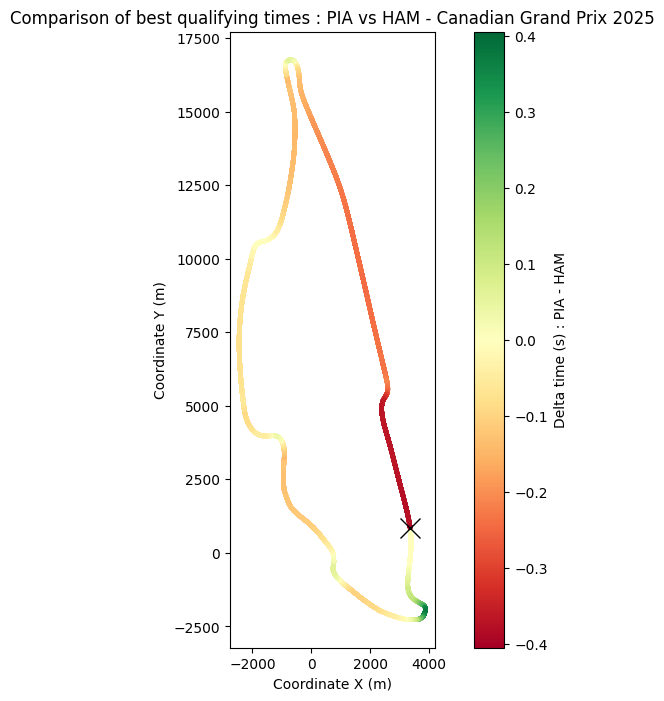

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
colormap = plt.cm.RdYlGn

abs_max_delta = plot_data['delta_time'].abs().max()

sc = ax.scatter(plot_data['x'], plot_data['y'],
                c=plot_data['delta_time'],
                cmap=colormap,
                vmin=-abs_max_delta, vmax=abs_max_delta,
                s=5, zorder=1)

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(f'Delta time (s) : {driver1} - {driver2}')

ax.plot(tel2.iloc[0]['X'], tel2.iloc[0]['Y'], 'x', markersize=15, color='black', zorder=2)

ax.set_aspect('equal', adjustable='box')
ax.set_title(f"Comparison of best qualifying times : {driver1} vs {driver2} - {gp} {year}")
ax.set_xlabel("Coordinate X (m)")
ax.set_ylabel("Coordinate Y (m)")
plt.show()
